In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import VOCSegmentation
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
class MakeClass(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class

    def forward(self, x):
        x[x == 255] = 21
        return F.one_hot(x.to(torch.int64), self.num_class).permute(0, 3, 1, 2)[0].float()

transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.PILToTensor(), 
        MakeClass(22)
    ]
)

train_ds = VOCSegmentation(
    root = "~/data", image_set = "train", download = True, year = "2012",
    transform = transform, 
    target_transform = target_transform
)

valid_ds = VOCSegmentation(
    root = "~/data", image_set = "trainval", download = True, year = "2012",
    transform = transform, 
    target_transform = target_transform    
)

test_ds = VOCSegmentation(
    root = "~/data", image_set = "val", download = True, year = "2012",
    transform = transform, 
    target_transform = target_transform
)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True, pin_memory = True, num_workers=24)

print("#Training Samples: {}".format(len(train_ds)))
print("#Validation Samples: {}".format(len(valid_ds)))
print("#Testing Samples: {}".format(len(test_ds)))
print("#Training Batch: {}".format(len(train_dl)))
print("#Validation Batch: {}".format(len(valid_dl)))
print("#Testing Batch: {}".format(len(test_dl)))

100%|█████████████████████████████████████████████████| 1999639040/1999639040 [3:30:28<00:00, 158343.50it/s]


Extracting /home/khoidh/data/VOCtrainval_11-May-2012.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2012.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2012.tar to /home/khoidh/data
Using downloaded and verified file: /home/khoidh/data/VOCtrainval_11-May-2012.tar
Extracting /home/khoidh/data/VOCtrainval_11-May-2012.tar to /home/khoidh/data
#Training Samples: 1464
#Validation Samples: 2913
#Testing Samples: 1449
#Training Batch: 46
#Validation Batch: 92
#Testing Batch: 46


Total #Class: 22
data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([22, 256, 256])
Number classes: 22
Classes: tensor([ 0, 15, 21])


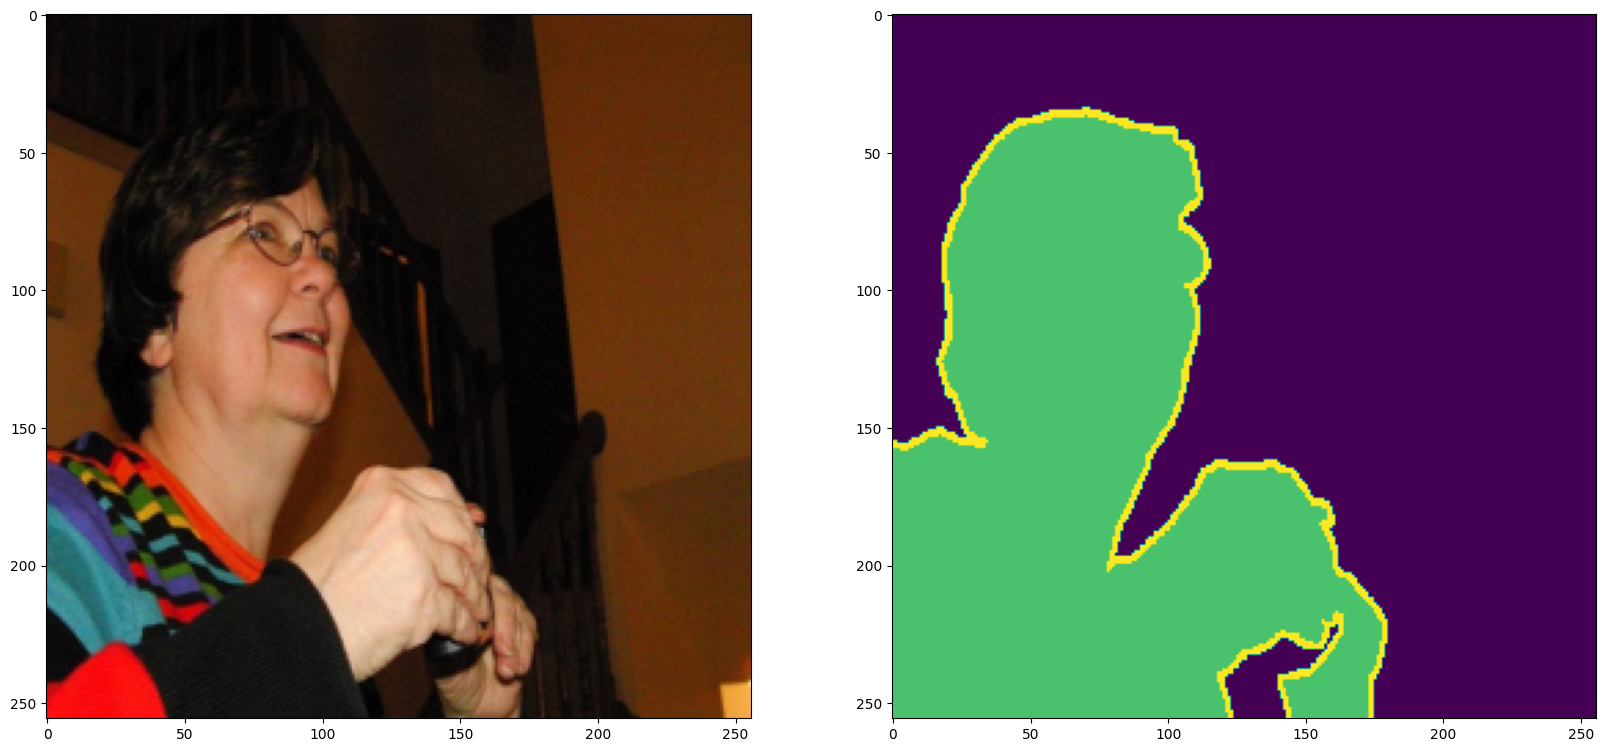

In [3]:
sample_data, sample_mask = train_ds[200]
total_num_class = 22

print(f"Total #Class: {total_num_class}")
print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")
num_class = sample_mask.shape[0]
print(f"Number classes: {num_class}")
print(f"Classes: {torch.unique(torch.argmax(sample_mask, dim = 0))}")

f, axarr = plt.subplots(1, 2, figsize=(20, 15))
axarr[0].imshow(sample_data.permute(1, -1, 0).numpy())
axarr[1].imshow(torch.argmax(sample_mask, dim = 0).unsqueeze(0).permute(1, -1, 0).numpy())

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [5]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [7]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, total_num_class, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [11]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, valid_mask in tqdm(valid_dl):
            valid_img = valid_img.to(device)
            valid_mask = valid_mask.to(device)
            
            valid_gen_mask = model(valid_img)
            valid_rec_loss = loss_fn(valid_gen_mask, valid_mask)
            valid_dice_loss = dice_loss(
                F.softmax(valid_gen_mask, dim=1).float(),
                valid_mask.float(),
                multiclass=True
            )
            valid_loss = valid_rec_loss + valid_dice_loss

            va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    mean_valid_loss = va_total_loss/len(valid_dl)

    if mean_valid_loss <= old_loss:
        old_loss = mean_valid_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss} - ValidLoss: {mean_valid_loss}")
model.load_state_dict(best_dct)

100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.49it/s]


Epoch: 0 - TrainLoss: 3.519927470580391 - ValidLoss: 2.980770712313445


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.83it/s]


Epoch: 1 - TrainLoss: 2.7403880046761553 - ValidLoss: 2.879604248896889


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.72it/s]


Epoch: 2 - TrainLoss: 2.2212936411733213 - ValidLoss: 1.9837187243544536


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.54it/s]


Epoch: 3 - TrainLoss: 1.9137427366298179 - ValidLoss: 1.8696864260279613


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.98it/s]


Epoch: 4 - TrainLoss: 1.795852163563604 - ValidLoss: 1.7831835850425388


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.70it/s]


Epoch: 5 - TrainLoss: 1.7665592768917913 - ValidLoss: 1.7609631781992705


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.67it/s]


Epoch: 6 - TrainLoss: 1.7227818266205166 - ValidLoss: 1.7203125966631847


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.76it/s]


Epoch: 7 - TrainLoss: 1.7052117663881052 - ValidLoss: 1.7184787055720454


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.67it/s]


Epoch: 8 - TrainLoss: 1.6803085959475974 - ValidLoss: 1.739909449349279


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00, 10.03it/s]


Epoch: 9 - TrainLoss: 1.657594260962113 - ValidLoss: 1.6460834210333617


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.84it/s]


Epoch: 10 - TrainLoss: 1.634305425312208 - ValidLoss: 1.636394114597984


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.72it/s]


Epoch: 11 - TrainLoss: 1.6163698020188704 - ValidLoss: 1.6285331819368445


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.54it/s]


Epoch: 12 - TrainLoss: 1.590029706125674 - ValidLoss: 1.5938222006611202


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch: 13 - TrainLoss: 1.572164817996647 - ValidLoss: 1.5935311032378154


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.92it/s]


Epoch: 14 - TrainLoss: 1.5579367305921472 - ValidLoss: 1.5711772506651671


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.91it/s]


Epoch: 15 - TrainLoss: 1.5337809816650723 - ValidLoss: 1.6408767107388247


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch: 16 - TrainLoss: 1.5291553165601648 - ValidLoss: 1.5438901600630388


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.71it/s]


Epoch: 17 - TrainLoss: 1.5074440137199734 - ValidLoss: 1.533664328896481


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.97it/s]


Epoch: 18 - TrainLoss: 1.4926083658052527 - ValidLoss: 1.5464664684689564


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.69it/s]


Epoch: 19 - TrainLoss: 1.4733956508014514 - ValidLoss: 1.5208629253117933


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.85it/s]


Epoch: 20 - TrainLoss: 1.4456187331158181 - ValidLoss: 1.4691730569238248


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.85it/s]


Epoch: 21 - TrainLoss: 1.450587430725927 - ValidLoss: 1.4542104977628458


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.62it/s]


Epoch: 22 - TrainLoss: 1.4230476565982983 - ValidLoss: 1.433990821890209


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.81it/s]


Epoch: 23 - TrainLoss: 1.409801052964252 - ValidLoss: 1.5146230737800184


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.51it/s]


Epoch: 24 - TrainLoss: 1.3951278639876323 - ValidLoss: 1.436021627291389


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.75it/s]


Epoch: 25 - TrainLoss: 1.3876821917036306 - ValidLoss: 1.4423196432383165


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.74it/s]


Epoch: 26 - TrainLoss: 1.3582576565120532 - ValidLoss: 1.3875755615856336


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.83it/s]


Epoch: 27 - TrainLoss: 1.3447803725367007 - ValidLoss: 1.482884855374046


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.93it/s]


Epoch: 28 - TrainLoss: 1.3368139266967773 - ValidLoss: 1.3855532342972963


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.84it/s]


Epoch: 29 - TrainLoss: 1.3076480031013489 - ValidLoss: 1.3490345886220103


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.53it/s]


Epoch: 30 - TrainLoss: 1.2989716503931128 - ValidLoss: 1.3983533226925393


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.86it/s]


Epoch: 31 - TrainLoss: 1.2784388428149016 - ValidLoss: 1.3595422435065974


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.58it/s]


Epoch: 32 - TrainLoss: 1.2843870857487554 - ValidLoss: 1.3235017799812814


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.66it/s]


Epoch: 33 - TrainLoss: 1.2433186626952628 - ValidLoss: 1.3202543990767521


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.67it/s]


Epoch: 34 - TrainLoss: 1.222890114006789 - ValidLoss: 1.3020511548156324


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch: 35 - TrainLoss: 1.2049804679725482 - ValidLoss: 1.2630515662224397


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.64it/s]


Epoch: 36 - TrainLoss: 1.2010176466858906 - ValidLoss: 1.2855542438185734


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.76it/s]


Epoch: 37 - TrainLoss: 1.1673026901224386 - ValidLoss: 1.2953911611567372


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00, 10.07it/s]


Epoch: 38 - TrainLoss: 1.1506394303363303 - ValidLoss: 1.2740289763264034


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.81it/s]


Epoch: 39 - TrainLoss: 1.1257232323936794 - ValidLoss: 1.2246793929649435


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00, 10.04it/s]


Epoch: 40 - TrainLoss: 1.0933472902878472 - ValidLoss: 1.2402923009965732


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.65it/s]


Epoch: 41 - TrainLoss: 1.0782996364261792 - ValidLoss: 1.1731680003197298


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.72it/s]


Epoch: 42 - TrainLoss: 1.0410795781923377 - ValidLoss: 1.193464017432669


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.76it/s]


Epoch: 43 - TrainLoss: 1.027215555958126 - ValidLoss: 1.2057752887839857


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.65it/s]


Epoch: 44 - TrainLoss: 1.0205695318139119 - ValidLoss: 1.1944917913364328


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.70it/s]


Epoch: 45 - TrainLoss: 0.9948279715102651 - ValidLoss: 1.1298236795093701


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.99it/s]


Epoch: 46 - TrainLoss: 0.9605559667815333 - ValidLoss: 1.1675036743931149


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.80it/s]


Epoch: 47 - TrainLoss: 0.9330403856609178 - ValidLoss: 1.1177418542944866


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.75it/s]


Epoch: 48 - TrainLoss: 0.9133860740972601 - ValidLoss: 1.1303839748320372


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.46it/s]


Epoch: 49 - TrainLoss: 0.8883419943892438 - ValidLoss: 1.1604839660551236


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.67it/s]


Epoch: 50 - TrainLoss: 0.8454175461893496 - ValidLoss: 1.069578999410505


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.31it/s]


Epoch: 51 - TrainLoss: 0.81004155330036 - ValidLoss: 1.074457675056613


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.75it/s]


Epoch: 52 - TrainLoss: 0.809794431147368 - ValidLoss: 1.0588383447864782


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.58it/s]


Epoch: 53 - TrainLoss: 0.77163583688114 - ValidLoss: 1.088979310963465


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.65it/s]


Epoch: 54 - TrainLoss: 0.748810122842374 - ValidLoss: 1.0705100116522417


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch: 55 - TrainLoss: 0.7309021872022877 - ValidLoss: 1.0615753599483033


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch: 56 - TrainLoss: 0.6968981332105139 - ValidLoss: 1.0345691338829373


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.55it/s]


Epoch: 57 - TrainLoss: 0.6727847132993781 - ValidLoss: 1.0299137584541156


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.66it/s]


Epoch: 58 - TrainLoss: 0.6653643004272295 - ValidLoss: 1.039155900478363


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.81it/s]


Epoch: 59 - TrainLoss: 0.6238747491784717 - ValidLoss: 0.9697023422821708


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.69it/s]


Epoch: 60 - TrainLoss: 0.6129994774642198 - ValidLoss: 0.9903183917960395


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch: 61 - TrainLoss: 0.5966565796862477 - ValidLoss: 1.011687998538432


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.50it/s]


Epoch: 62 - TrainLoss: 0.5965927385765574 - ValidLoss: 1.011753704884778


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.65it/s]


Epoch: 63 - TrainLoss: 0.5695662524389185 - ValidLoss: 1.0534466466178065


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.68it/s]


Epoch: 64 - TrainLoss: 0.5583023338214211 - ValidLoss: 1.0118601254147033


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.72it/s]


Epoch: 65 - TrainLoss: 0.5481498766204586 - ValidLoss: 1.0272682574780092


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.75it/s]


Epoch: 66 - TrainLoss: 0.5275756710249445 - ValidLoss: 0.9951494349085767


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.62it/s]


Epoch: 67 - TrainLoss: 0.4966320531523746 - ValidLoss: 0.965201097338096


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.62it/s]


Epoch: 68 - TrainLoss: 0.48769095151320746 - ValidLoss: 0.9636872595419055


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.91it/s]


Epoch: 69 - TrainLoss: 0.4792721919391466 - ValidLoss: 0.9784493446350098


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.58it/s]


Epoch: 70 - TrainLoss: 0.4553740354983703 - ValidLoss: 0.9456540864446888


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.61it/s]


Epoch: 71 - TrainLoss: 0.44738820843074634 - ValidLoss: 0.9507689249256382


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.47it/s]


Epoch: 72 - TrainLoss: 0.44988600780134613 - ValidLoss: 0.9696594716414161


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.58it/s]


Epoch: 73 - TrainLoss: 0.4374720901250839 - ValidLoss: 0.9647132885520873


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.67it/s]


Epoch: 74 - TrainLoss: 0.41312206309774646 - ValidLoss: 0.9499065610377685


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.53it/s]


Epoch: 75 - TrainLoss: 0.4046195784340734 - ValidLoss: 0.9535708887421567


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.93it/s]


Epoch: 76 - TrainLoss: 0.3919445030067278 - ValidLoss: 0.9494041781062665


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.54it/s]


Epoch: 77 - TrainLoss: 0.3835851077152335 - ValidLoss: 0.9328820391193681


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.57it/s]


Epoch: 78 - TrainLoss: 0.3691840865041899 - ValidLoss: 0.9257506073816962


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.38it/s]


Epoch: 79 - TrainLoss: 0.373010001104811 - ValidLoss: 0.9333745305952819


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.55it/s]


Epoch: 80 - TrainLoss: 0.3716113969035771 - ValidLoss: 0.9423710749201153


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch: 81 - TrainLoss: 0.37517387646695843 - ValidLoss: 0.9775056489135908


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.58it/s]


Epoch: 82 - TrainLoss: 0.3656205301699431 - ValidLoss: 0.9393947040257247


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.42it/s]


Epoch: 83 - TrainLoss: 0.36515709174715955 - ValidLoss: 0.9361789460577394


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.85it/s]


Epoch: 84 - TrainLoss: 0.36637094422526983 - ValidLoss: 0.9435530502511107


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.50it/s]


Epoch: 85 - TrainLoss: 0.3475205490122671 - ValidLoss: 0.9472468054812887


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.45it/s]


Epoch: 86 - TrainLoss: 0.34692866743906686 - ValidLoss: 0.9374368398085885


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.71it/s]


Epoch: 87 - TrainLoss: 0.33948797343865683 - ValidLoss: 0.9418080568961475


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.86it/s]


Epoch: 88 - TrainLoss: 0.33730402977570245 - ValidLoss: 0.9481494212928026


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.61it/s]


Epoch: 89 - TrainLoss: 0.33618084827195044 - ValidLoss: 0.9427999905917955


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.62it/s]


Epoch: 90 - TrainLoss: 0.33842557539110596 - ValidLoss: 0.9342727634002981


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.50it/s]


Epoch: 91 - TrainLoss: 0.3330830517022506 - ValidLoss: 0.9714643495238345


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.72it/s]


Epoch: 92 - TrainLoss: 0.3406363537778025 - ValidLoss: 0.9361703936820445


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.77it/s]


Epoch: 93 - TrainLoss: 0.3366169693029445 - ValidLoss: 0.9765294835619305


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.54it/s]


Epoch: 94 - TrainLoss: 0.33786248836828314 - ValidLoss: 0.942035566529502


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.57it/s]


Epoch: 95 - TrainLoss: 0.3324430322517519 - ValidLoss: 0.9379192493532015


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.91it/s]


Epoch: 96 - TrainLoss: 0.3318761632494304 - ValidLoss: 0.9411128863044407


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.53it/s]


Epoch: 97 - TrainLoss: 0.33865180579216586 - ValidLoss: 0.9779559866241787


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.63it/s]


Epoch: 98 - TrainLoss: 0.3220717544141023 - ValidLoss: 0.9348445173514925


100%|███████████████████████████████████████████████████████████████████████| 92/92 [00:09<00:00,  9.48it/s]

Epoch: 99 - TrainLoss: 0.324441515557144 - ValidLoss: 0.9418671377327131


<All keys matched successfully>

In [12]:
model.eval()
with torch.no_grad():
    ts_total_loss = 0
    for test_img, test_mask in tqdm(test_dl):
        test_img = test_img.to(device)
        test_mask = test_mask.to(device)
        
        test_gen_mask = model(test_img)
        test_rec_loss = loss_fn(test_gen_mask, test_mask)
        test_dice_loss = dice_loss(
            F.softmax(test_gen_mask, dim=1).float(),
            test_mask.float(),
            multiclass=True
        )
        test_loss = test_rec_loss + test_dice_loss

        ts_total_loss += test_loss.cpu().item()
mean_test_loss = ts_total_loss/len(test_dl)
print(f"TestLoss: {mean_test_loss}")

100%|███████████████████████████████████████████████████████████████████████| 46/46 [00:06<00:00,  6.91it/s]

TestLoss: 1.6084561762602434


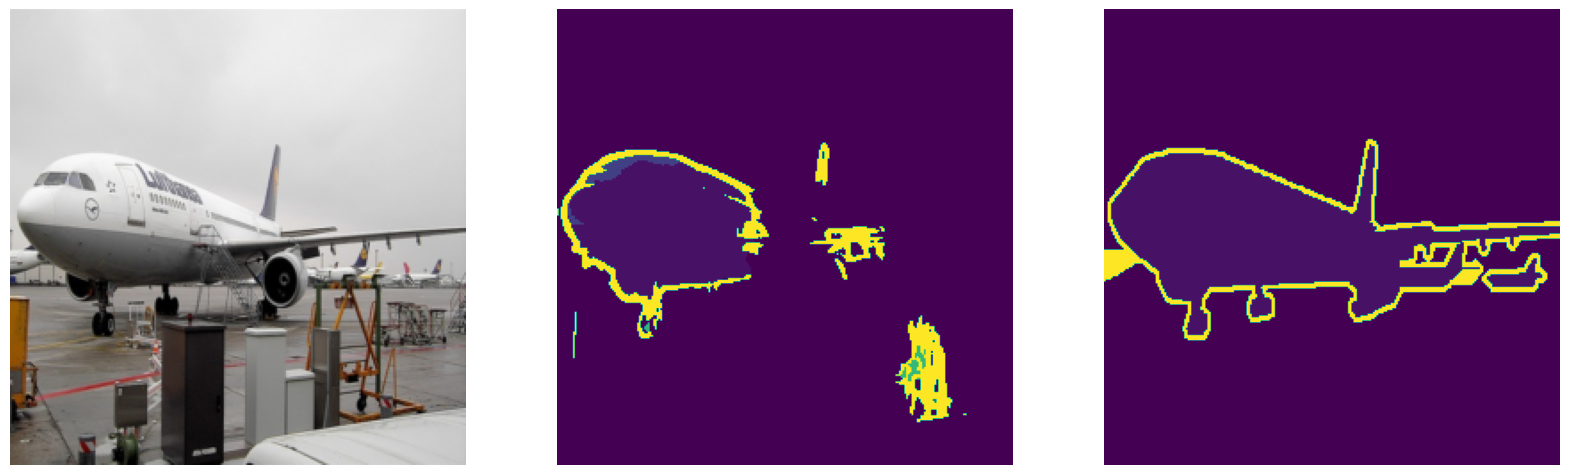

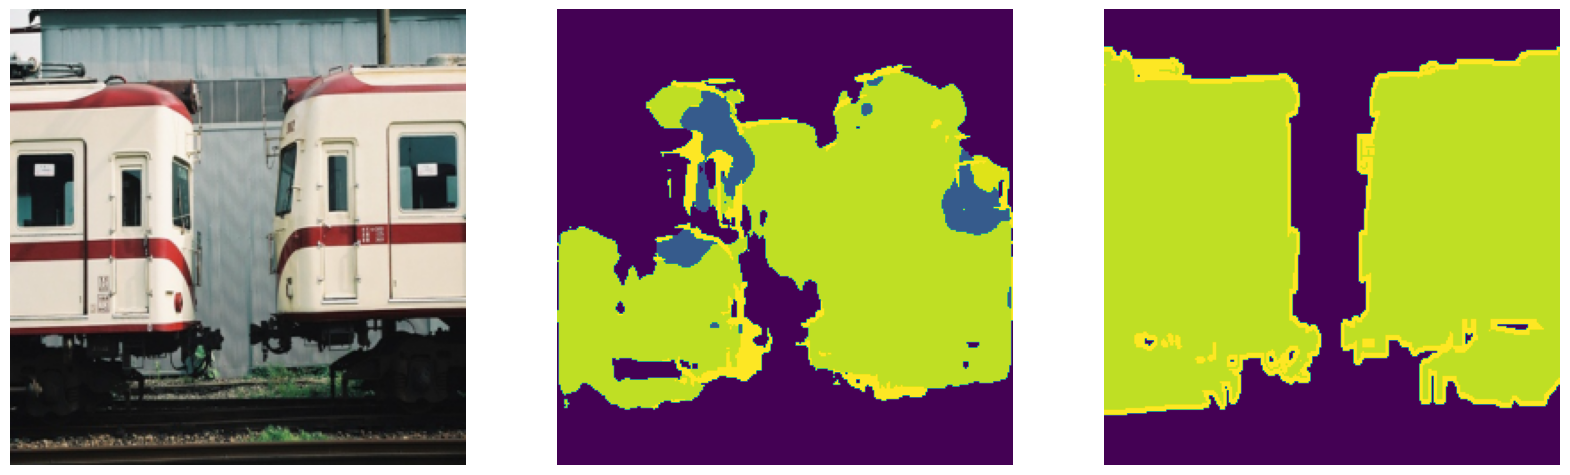

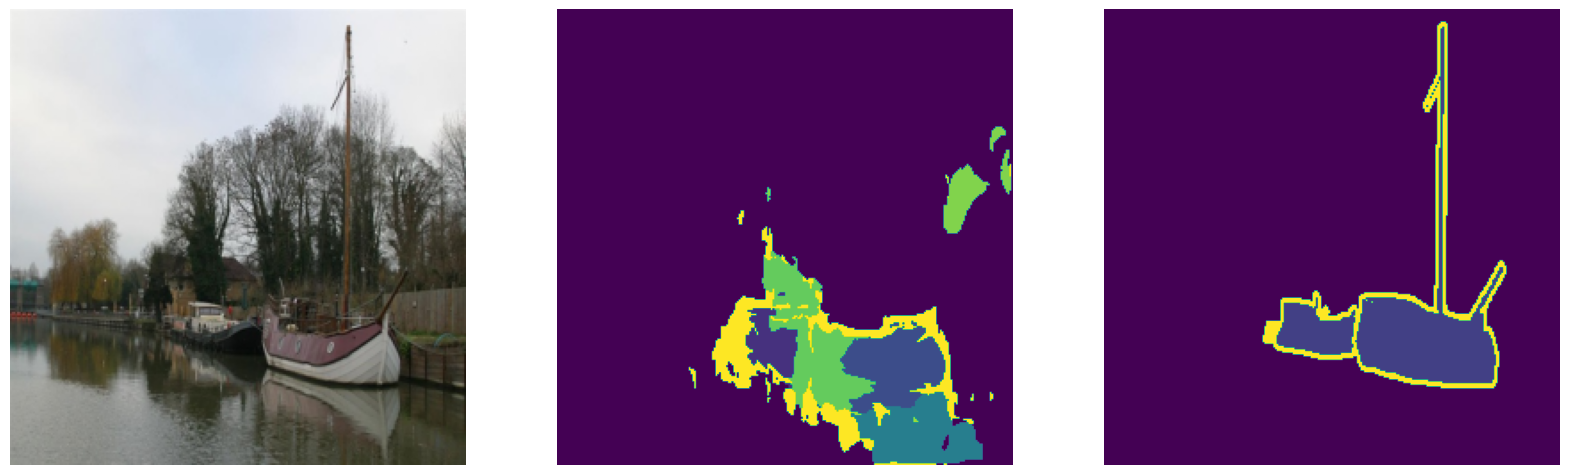

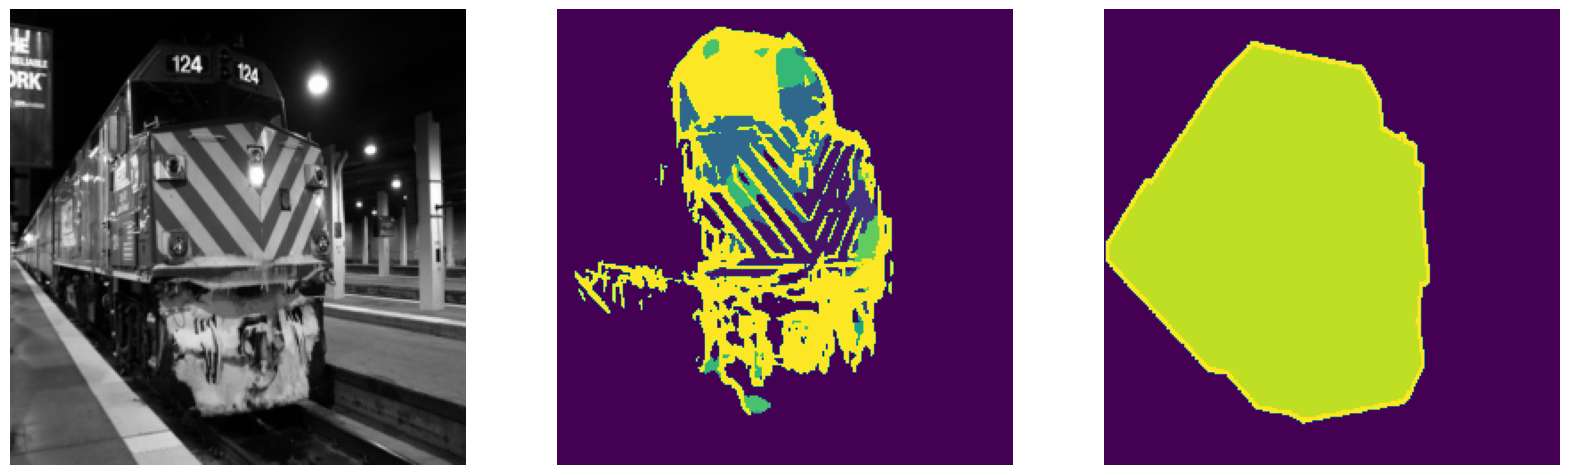

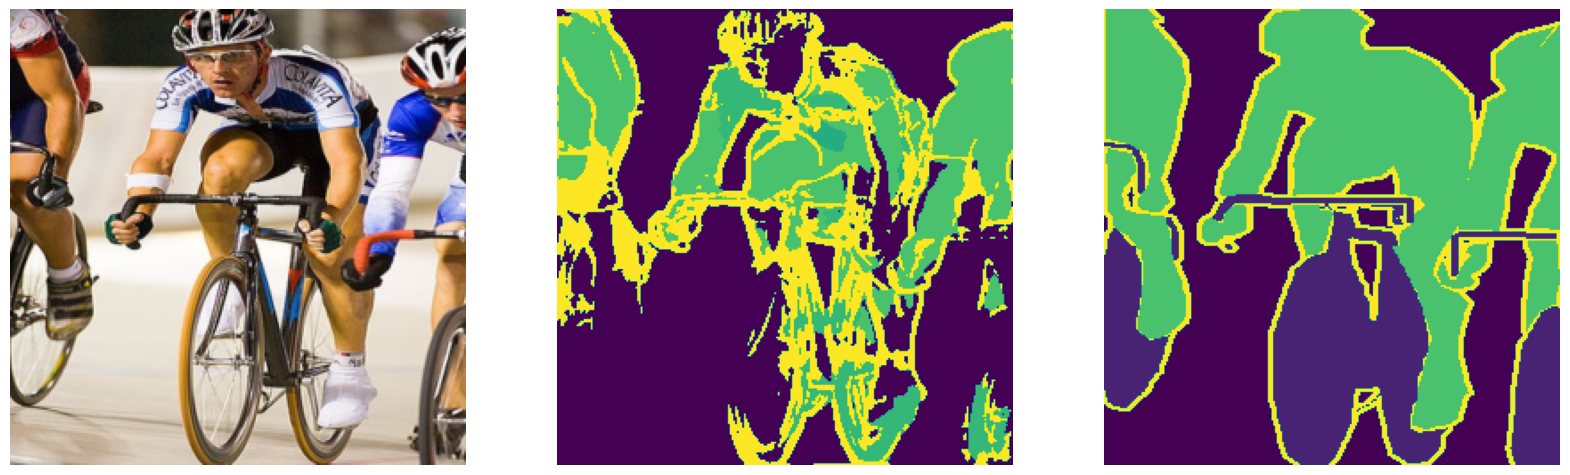

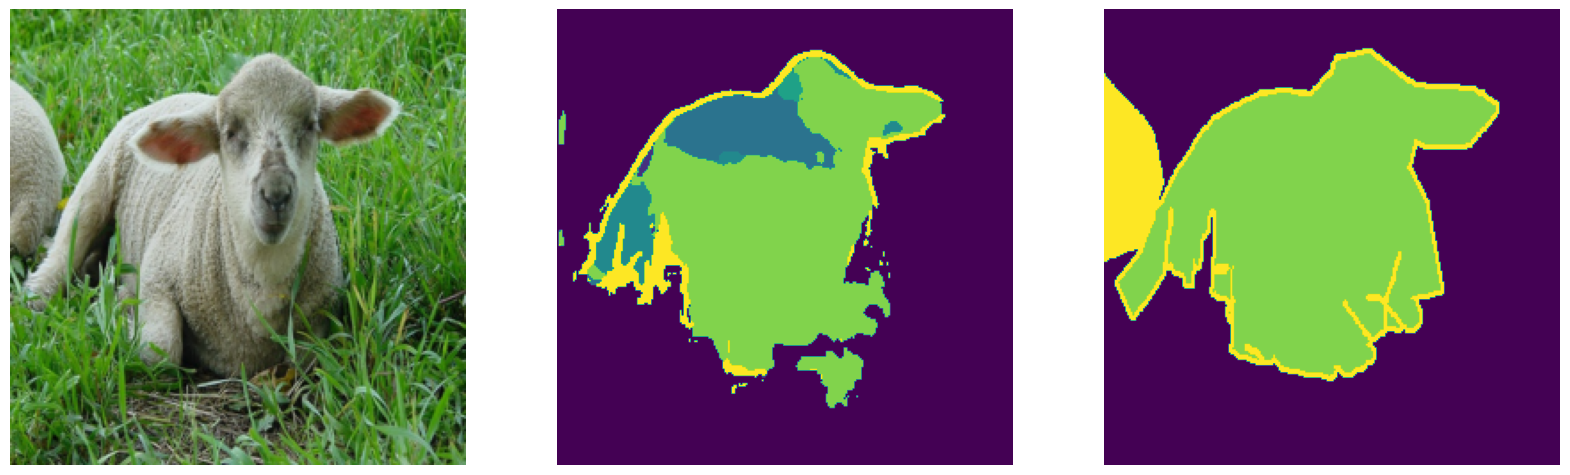

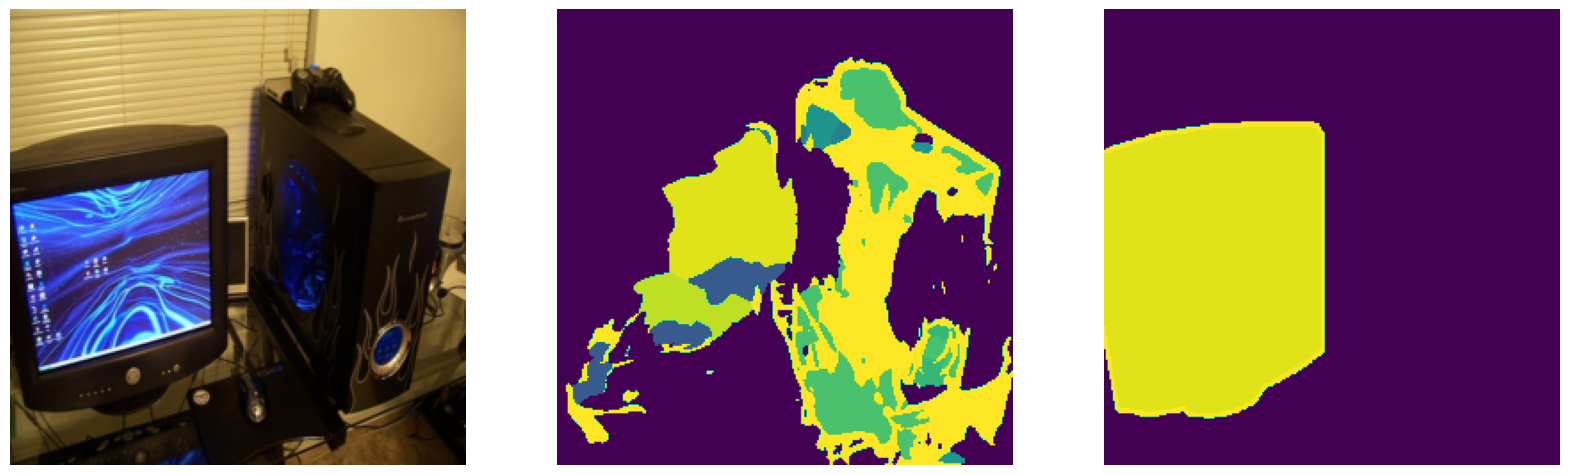

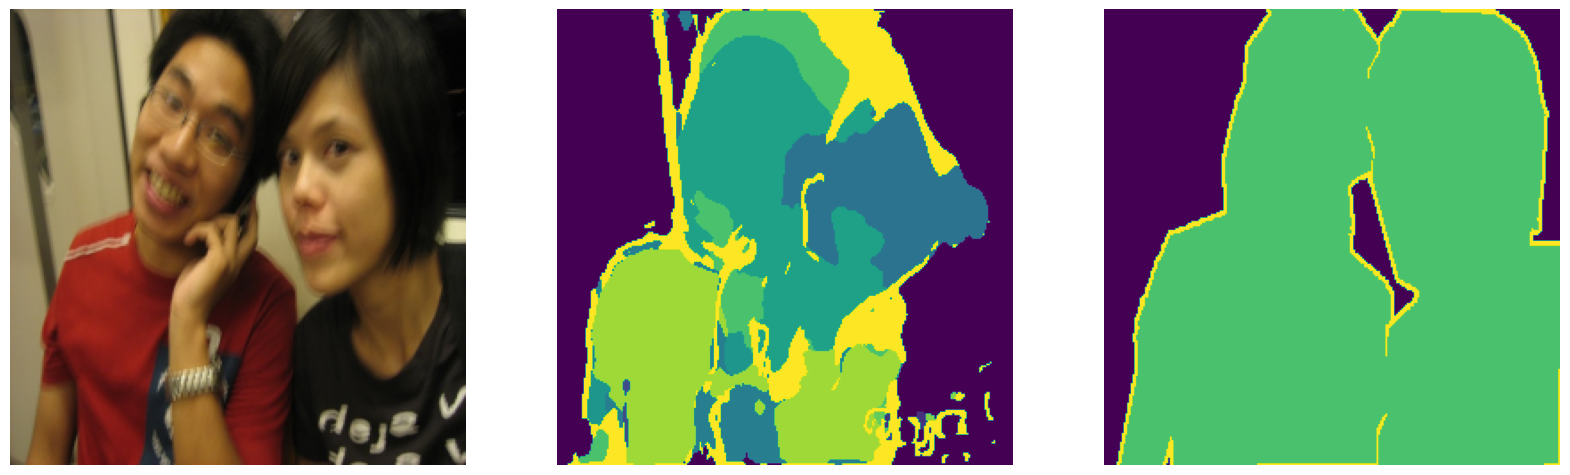

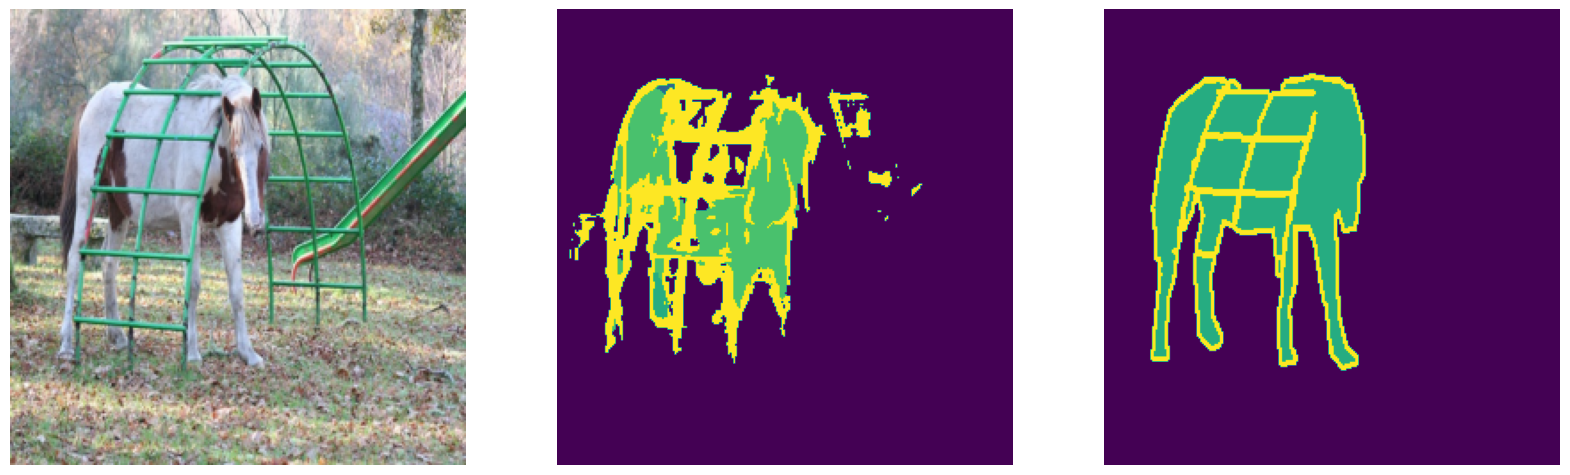

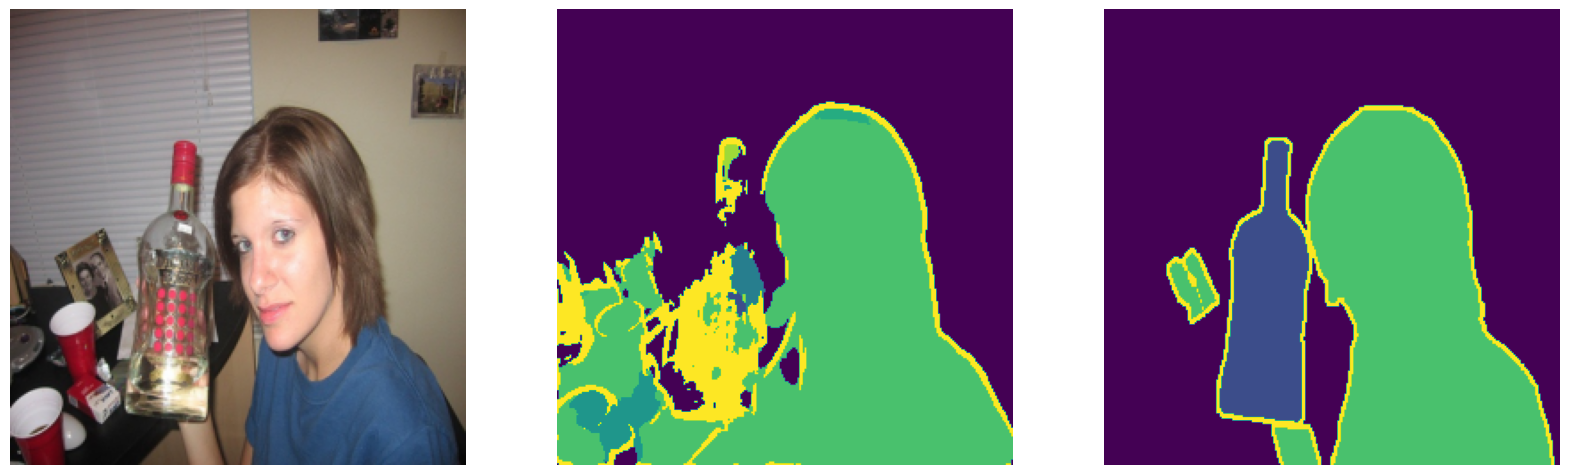

In [13]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = test_ds[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_mask = model(valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')